In [1]:
import numpy as np
from keras import models
from keras import layers

from matplotlib import pyplot as plt
%matplotlib notebook

Using TensorFlow backend.


## Data generation
We need a function which can generate with the proper structure.

The data structure is a list of binary module vectors per track

In [2]:
# Config parameters
det_width = 50
det_depth = 50

In [37]:
def sim_track(m, b):
    x = np.zeros([det_depth, det_width])
    hit_idxs = [round(m*l + b) for l in range(det_depth)]
    for row, idx in enumerate(hit_idxs):
        x[row, idx] = 1
    return x

def generate_track():
    """Sample track parameters and simulate propagation to produce hits"""
    b = np.random.random_sample()*(det_width - 1)
    # restrict slope to only generate tracks that traverse the entire detector
    mmax = (det_width - 1 - b) / (det_depth - 1)
    mmin = -b / det_depth
    #print(mmin, mmax)
    m = np.random.random_sample() * (mmax - mmin) + mmin
    #print(m, b)
    return sim_track(m, b)

def generate_tracks(n):
    """Generates N tracks in independent detector images"""
    tracks = [generate_track().reshape([1, det_depth, det_width]) for i in range(n)]
    return np.concatenate(tracks, axis=0)

def generate_noise(n, prob=0.1, skip_layers=5):
    """Generate uniform noise hits with probability prob and skipping some initial seed layers"""
    # One way to do this: generate random floats in [0,1]
    # and then convert the ones above threshold to binary
    noise_events = np.zeros([n, det_depth, det_width])
    noise_events[:,skip_layers:,:] = np.random.random_sample([n, det_depth-skip_layers, det_width]) < prob
    return noise_events

def generate_events(num_event, tracks_per_event):
    """Generates events with fixed number of tracks"""
    return sum([generate_tracks(num_event) for i in range(tracks_per_event)])

<IPython.core.display.Javascript object>


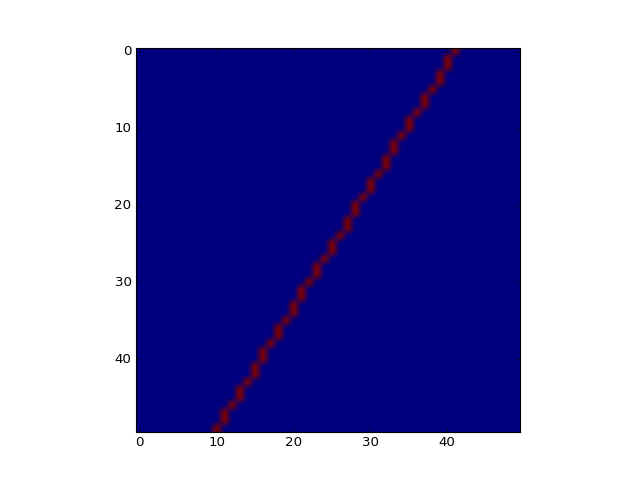

In [4]:
# This is what a track looks like in our "detector"
t = generate_track()
plt.figure()
plt.imshow(t)

In [5]:
tracks = generate_tracks(50000)
#print(tracks)

In [6]:
train_input = tracks[:,:-1,:]
train_target = tracks[:,1:,:]
print(train_input.shape)

(50000, 49, 50)


## Build the track fitting model

In [7]:
def build_model(num_hidden=10, length=det_depth-1, dim=det_width,
                loss='categorical_crossentropy',
                optimizer='Nadam', metrics=['accuracy']):
    inputs = layers.Input(shape=(length, dim))
    hidden = layers.LSTM(output_dim=num_hidden, return_sequences=True)(inputs)
    outputs = layers.TimeDistributed(layers.Dense(dim, activation='softmax'))(hidden)
    model = models.Model(input=inputs, output=outputs)
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    return model

In [8]:
# Instantiate the model
model1 = build_model()

# Train on the entire training set
model1.fit(train_input, train_target, batch_size=100, nb_epoch=5)

Epoch 1/5
50000/50000 [==============================] - 134s - loss: 2.3276 - acc: 0.3817   
Epoch 2/5
50000/50000 [==============================] - 126s - loss: 1.0518 - acc: 0.6607   
Epoch 3/5
50000/50000 [==============================] - 127s - loss: 0.7996 - acc: 0.6965   
Epoch 4/5
50000/50000 [==============================] - 130s - loss: 0.6873 - acc: 0.7264   
Epoch 5/5
50000/50000 [==============================] - 133s - loss: 0.6176 - acc: 0.7492   


In [9]:
# Get all of the training data predictions
train_pred = model1.predict(train_input)

<IPython.core.display.Javascript object>


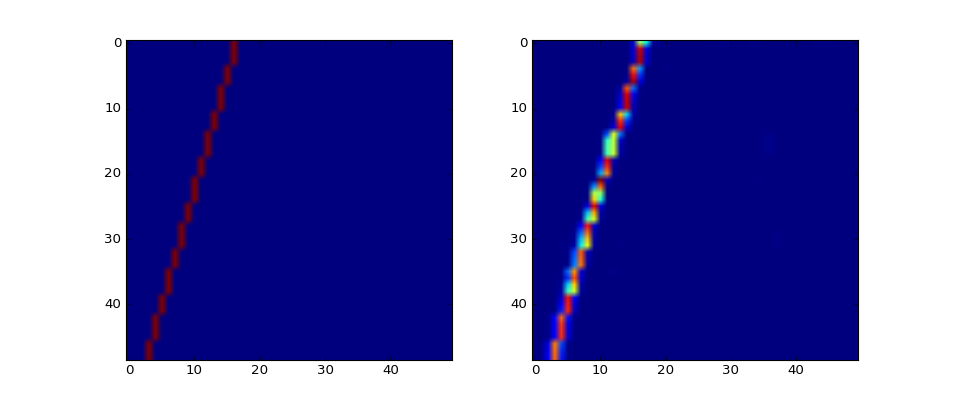

In [10]:
display_idx = 666
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.imshow(train_input[display_idx])
plt.subplot(122)
plt.imshow(train_pred[display_idx])

## Two-track events

In [18]:
# Try adding two tracks into one image and see how the model does without any retraining
t1 = generate_track()
t2 = generate_track()
t3 = t1 + t2

In [21]:
t3_input = t3.reshape([1, det_depth, det_width])[:,:-1,:]
t3_pred = model1.predict(t3_input)

<IPython.core.display.Javascript object>


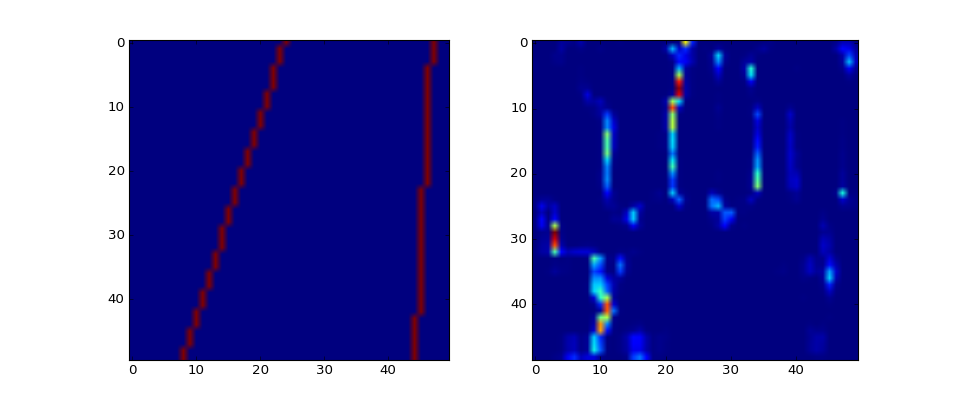

In [22]:
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.imshow(t3)
plt.subplot(122)
plt.imshow(t3_pred[0])

In [23]:
# Now lets generate events with 2 tracks each and train on that
events = generate_events(50000, 2)

In [29]:
# Create a new model
model2 = build_model(num_hidden=20)

In [30]:
train2_input = events[:,:-1,:]
train2_target = events[:,1:,:]

In [31]:
model2.fit(train2_input, train2_target, batch_size=100, nb_epoch=10)

Epoch 1/10
50000/50000 [==============================] - 135s - loss: 4.8209 - acc: 0.2336   
Epoch 2/10
50000/50000 [==============================] - 137s - loss: 3.3130 - acc: 0.3277   
Epoch 3/10
50000/50000 [==============================] - 131s - loss: 3.1652 - acc: 0.3346   
Epoch 4/10
50000/50000 [==============================] - 13480s - loss: 3.0978 - acc: 0.3385  
Epoch 5/10
50000/50000 [==============================] - 130s - loss: 3.0521 - acc: 0.3420   
Epoch 6/10
50000/50000 [==============================] - 129s - loss: 3.0177 - acc: 0.3448   
Epoch 7/10
50000/50000 [==============================] - 130s - loss: 2.9903 - acc: 0.3477   
Epoch 8/10
50000/50000 [==============================] - 129s - loss: 2.9675 - acc: 0.3500   
Epoch 9/10
50000/50000 [==============================] - 132s - loss: 2.9486 - acc: 0.3523   
Epoch 10/10
50000/50000 [==============================] - 129s - loss: 2.9327 - acc: 0.3550   


In [32]:
train2_pred = model2.predict(train2_input)

<IPython.core.display.Javascript object>


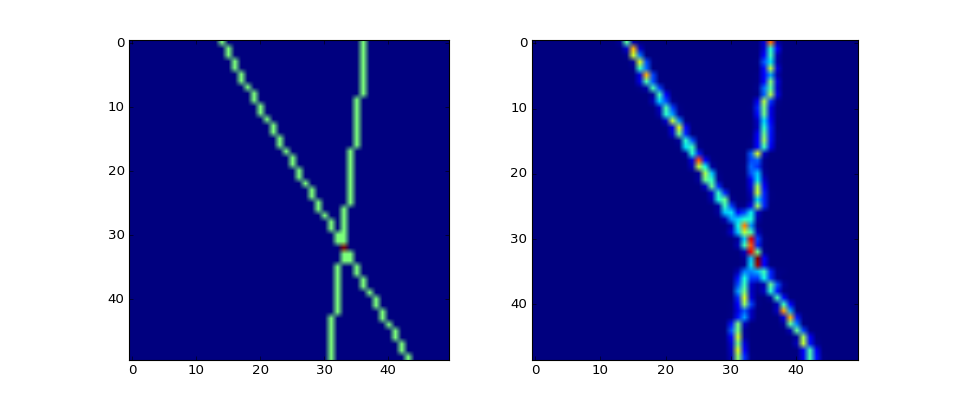

In [33]:
display_idx = 666
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.imshow(events[display_idx])
plt.subplot(122)
plt.imshow(train2_pred[display_idx])

## Single tracks with uniform noise

In [42]:
noise = generate_noise(len(tracks), skip_layers=10)
events = tracks + noise

<IPython.core.display.Javascript object>


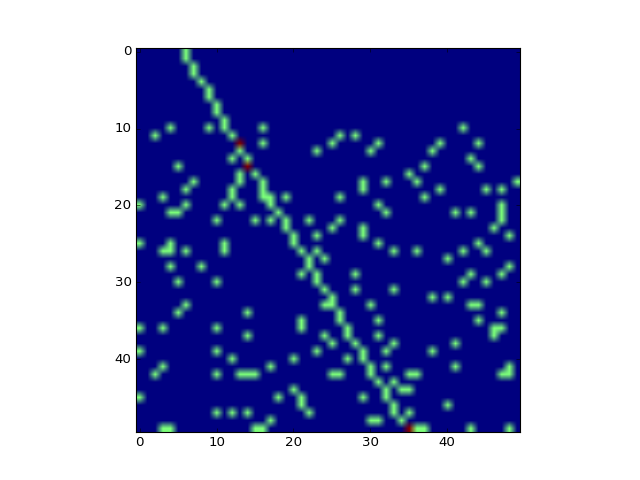

In [43]:
# Let's take a quick look at one of these noise events
plt.figure()
plt.imshow(events[66])

In training, the inputs to the network are the events with the tracks and noise. However, in this case the target is the not same event, but rather the track by itself (still shifted by 1 index). Let's see if we can get this to work.

In [44]:
# Instantiate the model
model3 = build_model(num_hidden=20)

In [45]:
# Define the inputs and target
train3_input = events[:,:-1,:]
train3_target = tracks[:,1:,:]

In [46]:
# Train the network
model3.fit(train3_input, train3_target, batch_size=100, nb_epoch=10)

Epoch 1/10
50000/50000 [==============================] - 130s - loss: 2.1990 - acc: 0.3404   
Epoch 2/10
50000/50000 [==============================] - 129s - loss: 1.2808 - acc: 0.5424   
Epoch 3/10
50000/50000 [==============================] - 129s - loss: 1.0676 - acc: 0.5958   
Epoch 4/10
50000/50000 [==============================] - 128s - loss: 0.9659 - acc: 0.6227   
Epoch 5/10
50000/50000 [==============================] - 127s - loss: 0.8925 - acc: 0.6421   
Epoch 6/10
50000/50000 [==============================] - 128s - loss: 0.8328 - acc: 0.6603   
Epoch 7/10
50000/50000 [==============================] - 5557s - loss: 0.7937 - acc: 0.6730   
Epoch 8/10
50000/50000 [==============================] - 135s - loss: 0.7618 - acc: 0.6842   
Epoch 9/10
50000/50000 [==============================] - 133s - loss: 0.7393 - acc: 0.6924   
Epoch 10/10
50000/50000 [==============================] - 129s - loss: 0.7135 - acc: 0.7019   


In [48]:
# Get the final predictions from the entire training set
train3_pred = model3.predict(train3_input)

<IPython.core.display.Javascript object>


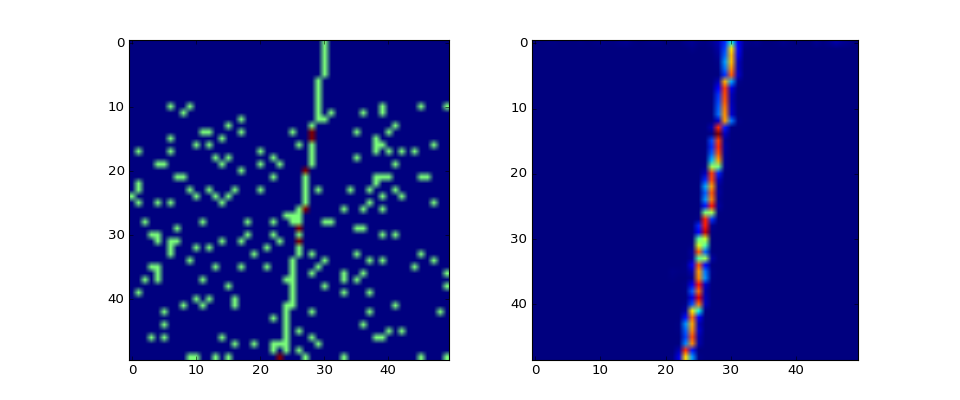

In [54]:
display_idx = 12050
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.imshow(events[display_idx])
plt.subplot(122)
plt.imshow(train3_pred[display_idx])

let's try to make it a little more difficult by decreasing the seed size and increasing the noise level

<IPython.core.display.Javascript object>


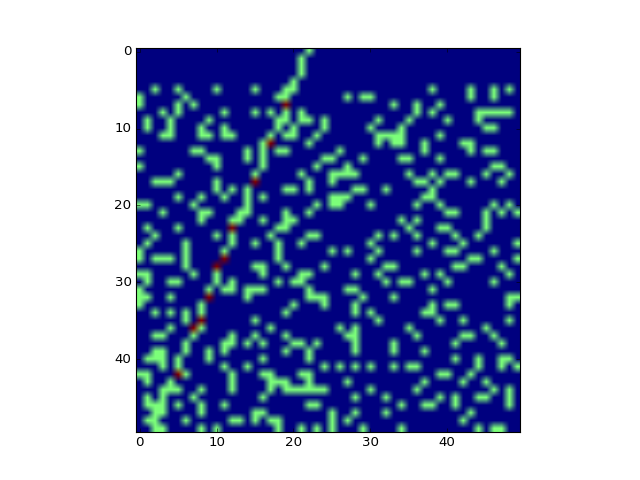

In [55]:
noise = generate_noise(len(tracks), skip_layers=5, prob=0.2)
events = tracks + noise
model4 = build_model(num_hidden=20)
train4_input = events[:,:-1,:]
train4_target = tracks[:,1:,:]
plt.figure()
plt.imshow(events[10])

In [56]:
model4.fit(train4_input, train4_target, batch_size=100, nb_epoch=10)
train4_pred = model4.predict(train4_input)

Epoch 1/10
50000/50000 [==============================] - 132s - loss: 2.5490 - acc: 0.2572   
Epoch 2/10
50000/50000 [==============================] - 141s - loss: 1.6302 - acc: 0.4200   
Epoch 3/10
50000/50000 [==============================] - 150s - loss: 1.3874 - acc: 0.4882   
Epoch 4/10
50000/50000 [==============================] - 154s - loss: 1.2525 - acc: 0.5254   
Epoch 5/10
50000/50000 [==============================] - 151s - loss: 1.2084 - acc: 0.5392   
Epoch 6/10
50000/50000 [==============================] - 152s - loss: 1.1216 - acc: 0.5625   
Epoch 7/10
50000/50000 [==============================] - 157s - loss: 1.0769 - acc: 0.5766   
Epoch 8/10
50000/50000 [==============================] - 161s - loss: 1.0656 - acc: 0.5831   
Epoch 9/10
50000/50000 [==============================] - 173s - loss: 1.0268 - acc: 0.5936   
Epoch 10/10
50000/50000 [==============================] - 138s - loss: 1.0308 - acc: 0.5969   


<IPython.core.display.Javascript object>


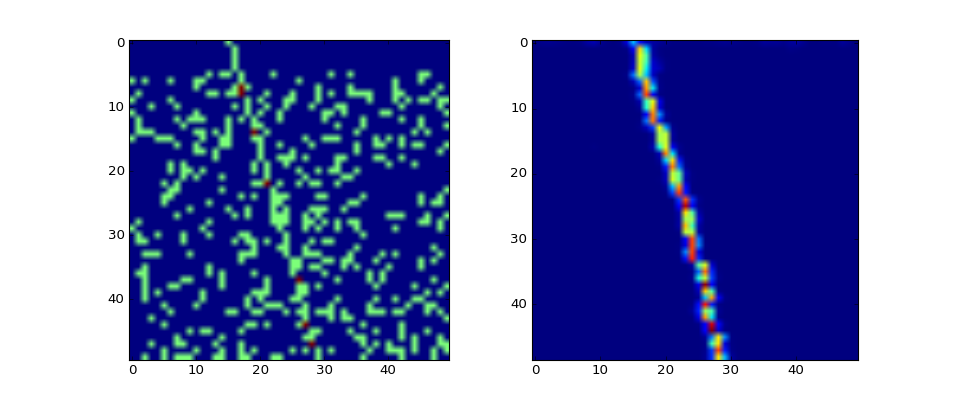

In [66]:
display_idx = 111
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.imshow(events[display_idx])
plt.subplot(122)
plt.imshow(train4_pred[display_idx])

<IPython.core.display.Javascript object>


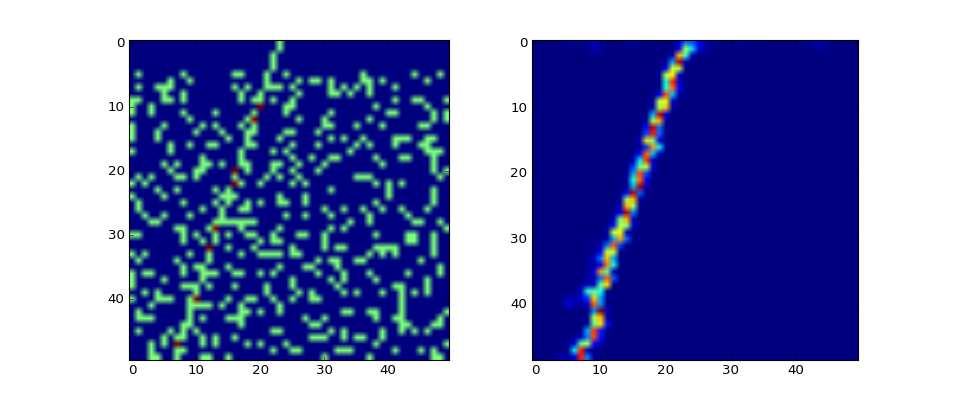

In [60]:
display_idx = 444
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.imshow(events[display_idx])
plt.subplot(122)
plt.imshow(train4_pred[display_idx])

<IPython.core.display.Javascript object>


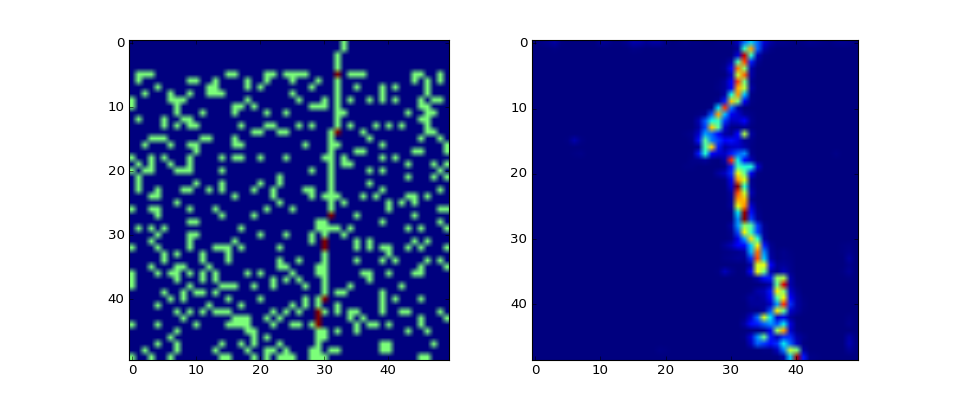

In [64]:
display_idx = 2222
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.imshow(events[display_idx])
plt.subplot(122)
plt.imshow(train4_pred[display_idx])